In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-12 19:45:20.714630: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-12 19:45:22.085667: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-12 19:45:22.127175: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-12 19:45:22.127223: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-12 19:45:22.144696: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-12 19:45:22.144764: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-12 19:45:22.152133: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

refit_gen_GASF_13m_100S5X_15A166006_R82_80-20


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['HEKA', 'fridge/freezer', 'audio system', 'breadmaker', 'broadband router', 'computer', 'dehumidifier', 'dish washer', 'electric space heater', 'food processor', 'pond pump', 'television', 'tumble dryer', 'washer dryer', 'washing machine']
{0: 0.3663356504468719, 1: 0.22525951557093427, 2: 6.4672023374726075, 3: 34.85669291338583, 4: 4.910482529118137, 5: 0.43032954214056574, 6: 18.068571428571428, 7: 2.8259176508139165, 8: 11.852208835341365, 9: 12.611965811965812, 10: 2.7789077212806026, 11: 0.2799203262828417, 12: 7.359600997506234, 13: 38.32727272727273, 14: 2.2073298429319372}
 
Tests 
HEKA test: 6042 train: 24168
fridge/freezer test: 9826 train: 39304
audio system test: 342 train: 1369
breadmaker test: 64 train: 254
broadband router test: 451 train: 1803
computer test: 5143 train: 20574
dehumidifier test: 123 train: 490
dish washer test: 783 train: 3133
electric space heater test: 187 train: 747
food processor test: 175 train: 702
pond pump test: 796 train: 3186
television test:

In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/BI_LSTM/refit/TL/refit_82_iawe, eco, redd, ukdale_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data refit training on model iawe seed 82
reading data, printing stats: 
['HEKA', 'fridge/freezer', 'audio system', 'breadmaker', 'broadband router', 'computer', 'dehumidifier', 'dish washer', 'electric space heater', 'food processor', 'pond pump', 'television', 'tumble dryer', 'washer dryer', 'washing machine']
{0: 0.3663356504468719, 1: 0.22525951557093427, 2: 6.4672023374726075, 3: 34.85669291338583, 4: 4.910482529118137, 5: 0.43032954214056574, 6: 18.068571428571428, 7: 2.8259176508139165, 8: 11.852208835341365, 9: 12.611965811965812, 10: 2.7789077212806026, 11: 0.2799203262828417, 12: 7.359600997506234, 13: 38.32727272727273, 14: 2.2073298429319372}
 
Tests 
HEKA test: 6042 train: 24168
fridge/freezer test: 9826 train: 39304
audio system test: 342 train: 1369
breadmaker test: 64 train: 254
broadband router test: 451 train: 1803
computer test: 5143 train: 20574
dehumidifier test: 123 train: 490
dish washer test: 783 train: 3133
electric space heater test: 187 train: 7

2022-02-12 19:45:39.131872: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-12 19:45:39.133539: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-12 19:45:39.133838: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-12 19:45:40.002756: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-12 19:45:40.002793: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-12 19:45:40.002903: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-12 19:45:40.003510: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-12 19:45:47.819263: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-12 19:45:47.840518: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/50


2022-02-12 19:45:51.380814: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-12 19:45:52.115675: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-12 19:45:52.959835: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-12 19:45:53.718422: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


4151/4151 - 87s - loss: 1.4902 - accuracy: 0.4841
Epoch 2/50
4151/4151 - 123s - loss: 1.3026 - accuracy: 0.5169
Epoch 3/50
4151/4151 - 116s - loss: 1.2528 - accuracy: 0.5302
Epoch 4/50
4151/4151 - 118s - loss: 1.2256 - accuracy: 0.5365
Epoch 5/50
4151/4151 - 115s - loss: 1.1938 - accuracy: 0.5419
Epoch 6/50
4151/4151 - 117s - loss: 1.1840 - accuracy: 0.5476
Epoch 7/50
4151/4151 - 117s - loss: 1.1687 - accuracy: 0.5524
Epoch 8/50
4151/4151 - 113s - loss: 1.1716 - accuracy: 0.5546
Epoch 9/50
4151/4151 - 117s - loss: 1.1579 - accuracy: 0.5530
Epoch 10/50
4151/4151 - 116s - loss: 1.1474 - accuracy: 0.5565
Epoch 11/50
4151/4151 - 118s - loss: 1.1356 - accuracy: 0.5546
Epoch 12/50
4151/4151 - 115s - loss: 1.1305 - accuracy: 0.5625
Epoch 13/50
4151/4151 - 113s - loss: 1.1291 - accuracy: 0.5608
Epoch 14/50
4151/4151 - 115s - loss: 1.1239 - accuracy: 0.5617
Epoch 15/50
4151/4151 - 112s - loss: 1.1228 - accuracy: 0.5677
Epoch 16/50
4151/4151 - 112s - loss: 1.1346 - accuracy: 0.5674
Epoch 17/50
4

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
4151/4151 - 84s - loss: 1.2398 - accuracy: 0.5301
Epoch 2/50
4151/4151 - 128s - loss: 0.9911 - accuracy: 0.5810
Epoch 3/50
4151/4151 - 133s - loss: 0.9463 - accuracy: 0.5979
Epoch 4/50
4151/4151 - 134s - loss: 0.9177 - accuracy: 0.6081
Epoch 5/50
4151/4151 - 133s - loss: 0.8993 - accuracy: 0.6124
Epoch 6/50
4151/4151 - 131s - loss: 0.8859 - accuracy: 0.6174
Epoch 7/50
4151/4151 - 132s - loss: 0.8703 - accuracy: 0.6276
Epoch 8/50
4151/4151 - 132s - loss: 0.8569 - accuracy: 0.6273
Epoch 9/50
4151/4151 - 131s - loss: 0.8434 - accuracy: 0.6283
Epoch 10/50
4151/4151 - 131s - loss: 0.8455 - accuracy: 0.6294
Epoch 11/50
4151/4151 - 131s - loss: 0.8462 - accuracy: 0.6332
Epoch 12/50
4151/4151 - 133s - loss: 0.8337 - accuracy: 0.6353
Epoch 13/50
4151/4151 - 128s - loss: 0.8350 - accuracy: 0.6308
Epoch 14/50
4151/4151 - 131s - loss: 0.8135 - accuracy: 0.6341
Epoch 15/50
4151/4151 - 134s - loss: 0.8145 - accuracy: 0.6365
Epoch 16/50
4151/4151 - 130s - l

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
4151/4151 - 84s - loss: 1.2871 - accuracy: 0.5059
Epoch 2/50
4151/4151 - 131s - loss: 1.0719 - accuracy: 0.5559
Epoch 3/50
4151/4151 - 133s - loss: 1.0134 - accuracy: 0.5701
Epoch 4/50
4151/4151 - 132s - loss: 0.9903 - accuracy: 0.5746
Epoch 5/50
4151/4151 - 131s - loss: 0.9666 - accuracy: 0.5837
Epoch 6/50
4151/4151 - 132s - loss: 0.9664 - accuracy: 0.5881
Epoch 7/50
4151/4151 - 128s - loss: 0.9518 - accuracy: 0.6024
Epoch 8/50
4151/4151 - 131s - loss: 0.9418 - accuracy: 0.5970
Epoch 9/50
4151/4151 - 123s - loss: 0.9432 - accuracy: 0.5997
Epoch 10/50
4151/4151 - 126s - loss: 0.9179 - accuracy: 0.6055
Epoch 11/50
4151/4151 - 126s - loss: 0.9300 - accuracy: 0.6108
Epoch 12/50
4151/4151 - 131s - loss: 0.9129 - accuracy: 0.6103
Epoch 13/50
4151/4151 - 127s - loss: 0.9168 - accuracy: 0.6076
Epoch 14/50
4151/4151 - 130s - loss: 0.9053 - accuracy: 0.6141
Epoch 15/50
4151/4151 - 127s - loss: 0.9089 - accuracy: 0.6137
Epoch 16/50
4151/4151 - 129s - l

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
4151/4151 - 84s - loss: 1.1230 - accuracy: 0.5987
Epoch 2/50
4151/4151 - 127s - loss: 0.8981 - accuracy: 0.6551
Epoch 3/50
4151/4151 - 129s - loss: 0.8457 - accuracy: 0.6758
Epoch 4/50
4151/4151 - 129s - loss: 0.8327 - accuracy: 0.6838
Epoch 5/50
4151/4151 - 131s - loss: 0.8162 - accuracy: 0.6883
Epoch 6/50
4151/4151 - 129s - loss: 0.8105 - accuracy: 0.6847
Epoch 7/50
4151/4151 - 127s - loss: 0.7993 - accuracy: 0.6937
Epoch 8/50
4151/4151 - 125s - loss: 0.7901 - accuracy: 0.6978
Epoch 9/50
4151/4151 - 130s - loss: 0.7753 - accuracy: 0.6985
Epoch 10/50
4151/4151 - 128s - loss: 0.7784 - accuracy: 0.7011
Epoch 11/50
4151/4151 - 131s - loss: 0.7689 - accuracy: 0.7001
Epoch 12/50
4151/4151 - 128s - loss: 0.7647 - accuracy: 0.7064
Epoch 13/50
4151/4151 - 127s - loss: 0.7670 - accuracy: 0.7062
Epoch 14/50
4151/4151 - 128s - loss: 0.7443 - accuracy: 0.7071
Epoch 15/50
4151/4151 - 129s - loss: 0.7477 - accuracy: 0.7098
Epoch 16/50
4151/4151 - 128s - l

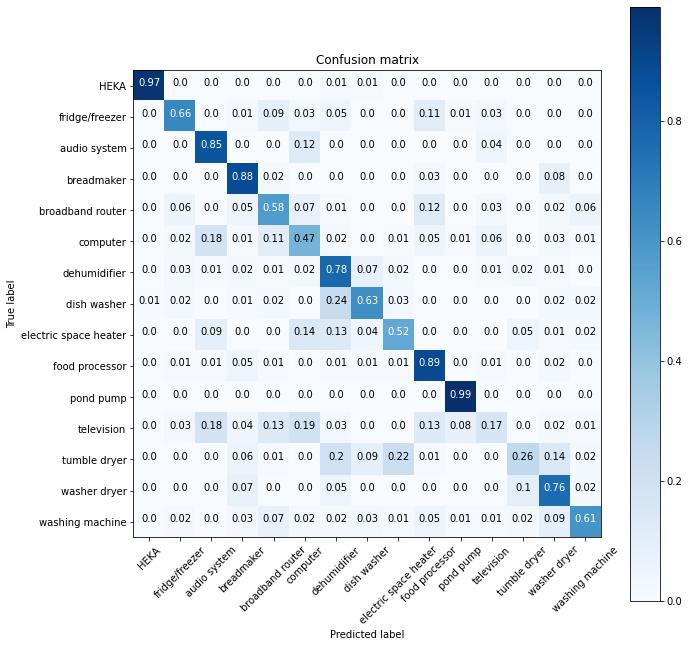

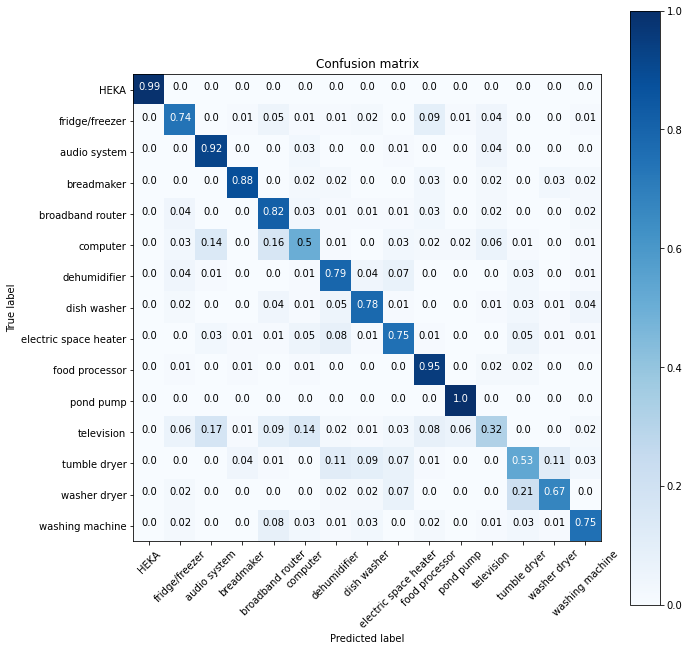

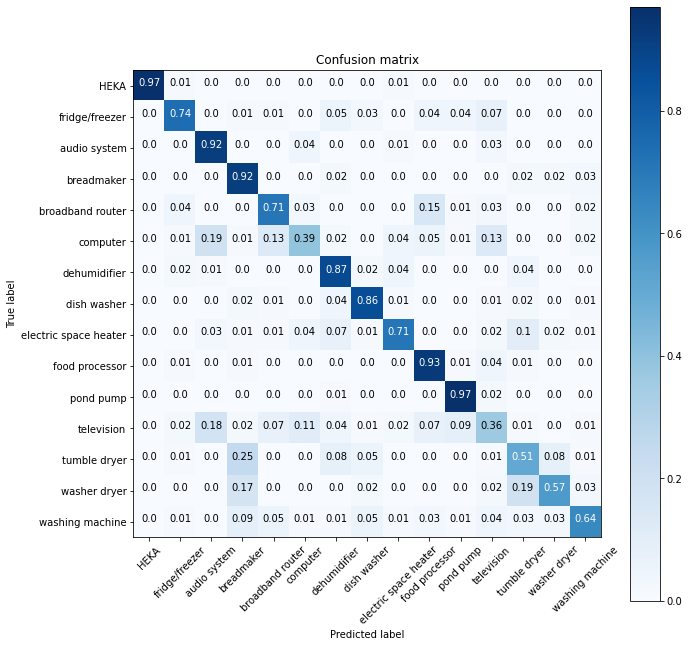

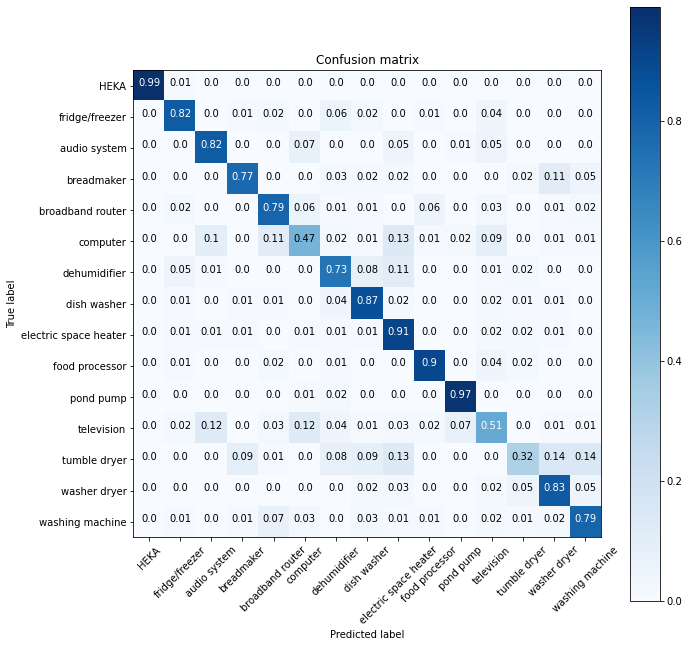

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()